# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - Public transport stop
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to download street network from OpenStreetMap and then calculate network accessibility to the public transit stop. Stop data is obtained from gtfs data. 


Note: pandana currently only runs on Python 2.

In [1]:
import sys
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [1]:
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape,Point, LineString, Polygon
import config

#import pandana library
import pandana
from pandana.loaders import osm

import warnings
warnings.filterwarnings(action='once')

ox.config(use_cache=True, log_console=True)
ox.__version__

ModuleNotFoundError: No module named 'pandana'

## Set up configuration 

In [7]:
suffix = config.time

place = config.places.values()[0]
place

'Phoenix, Arizona, USA'

In [3]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10

In [4]:
# configure filenames to save/load POI and network datasets
OSM_folder = config.OSM_data_loc
gtfs_folder = config.gtfs_data_loc
G_filename = '{studyregion}_walk{suffix}.graphml'.format(studyregion = place, suffix = config.time)

In [5]:
# keyword arguments to pass for the matplotlib figure
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10)}


# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## Load the metro stop 
GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [6]:
gtfs_stops = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/stops.txt')
gdf_stops = gpd.GeoDataFrame(gtfs_stops)

In [7]:
#define geometry
gdf_stops[['stop_lat', 'stop_lon']]  = gdf_stops[['stop_lat', 'stop_lon']].astype(float)
gdf_stops['geometry'] = gdf_stops.apply(lambda row: Point((row['stop_lon'], row['stop_lat'])), axis=1)

## Load the OSM streetnetwork graph using OSMnx

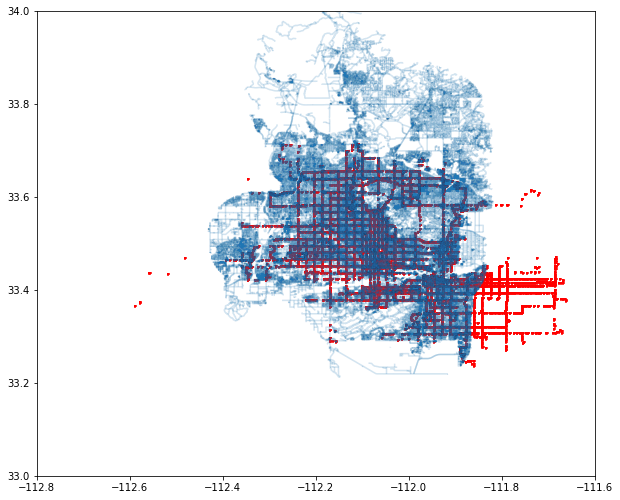

In [8]:
G_osm_walk = ox.load_graphml(G_filename, folder = OSM_folder)
gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)

#plot metro stops with OSM all street network
fig, ax = plt.subplots(figsize=(10, 10))
ax = gdf_osm_walk_edges.plot(ax=ax, alpha=0.1)
ax = gdf_stops.plot(ax=ax, color='red', marker='+', markersize=9)
ax.set_ylim((33,34))
ax.set_xlim((-112.8, -111.6))
#ax.set_axis_off()
#fig.suptitle('Meto stops', fontsize=14, fontweight='bold')
#fig.text(0.1, 0, 'Note: OSM street network')
plt.show()

## Load the OSM graphml and create network via Pandana

Reference:
[gdf node and edge attribute](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html)  
[Pandana Network function](https://udst.github.io/pandana/tutorial.html) 


In [9]:
start_time = time.time()
if os.path.isfile(OSM_folder + "/" + G_filename):
    # if a street network file already exists, load the network graph
    G_osm_walk = ox.load_graphml(G_filename, folder = OSM_folder)
    # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    
    # get network from Pandana
    network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    method = 'loaded from graphml'
else:
    # otherwise, query the OSM API for the street network 
    G_osm_walk = ox.graph_from_place(place, network_type= 'walk', retain_all=True, buffer_dist=1e4)
      # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    
    # get network from Pandana
    network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    method = 'downloaded from OSM'

print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),


Network with 252,049 nodes loaded from graphml in 767.95 secs


## Calculate accessibility to the amenity we retrieved

In [10]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [26]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', maxdist=distance, maxitems=num_pois, x_col=gdf_stops['stop_lon'], y_col=gdf_stops['stop_lat'])

In [28]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

252,049 nodes


,1,2,3,4,5,6,7,8,9,10
1707868160,358.716003,391.092987,560.114014,667.807983,795.690002,842.484985,948.228027,982.604980,1000.000000,1000.000000
5267449416,426.302002,448.871002,516.677002,905.786011,905.786011,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
6418508459,428.661987,433.368988,478.022003,490.072998,504.140015,566.739014,634.203003,634.203003,641.189026,673.997986
41874681,714.374023,849.947021,849.947021,928.213989,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
1663041551,364.121002,414.587006,455.786987,479.523010,492.197998,500.239014,510.865997,519.395996,530.276978,586.911987


## Plot accessibility from each node to public transport stop

Text(0.5,1,'Walking distance (1000m) to nearest transit stops (gtfs), Phoenix, Arizona, USA')

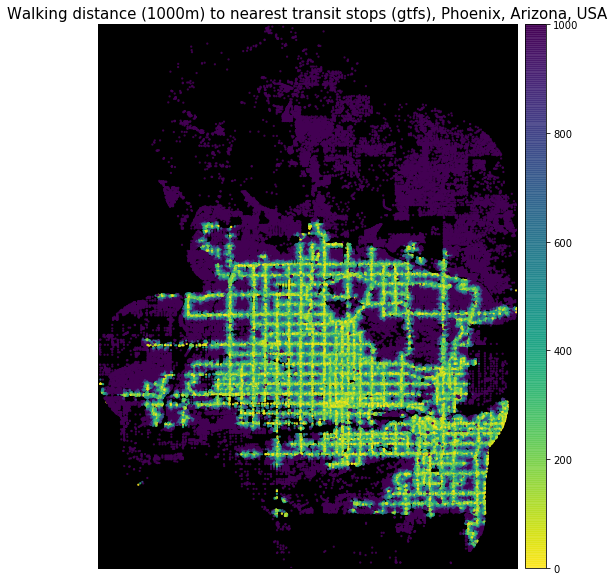

In [33]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance ({}m) to nearest transit stops (gtfs), {}'.format(distance, place), fontsize=15)
#fig.savefig('images/accessibility-stops-phx.png', dpi=200, bbox_inches='tight')